In [32]:
tf.keras.backend.clear_session()

In [17]:

from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import GlobalMaxPool2D
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.utils import np_utils, generic_utils
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import preprocessing

In [18]:
nb_classes = 27

In [19]:
model = Sequential()
#`channels_last` corresponds to inputs with shape `(batch, spatial_dim1, spatial_dim2, spatial_dim3, channels)`
strides = (1,1,1)
kernel_size = (3, 3, 3)
model.add(Conv3D(32, kernel_size, strides=strides, activation='relu', padding='same', input_shape=(32, 64, 96, 3)))
print(model.output_shape)
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
print(model.output_shape)

model.add(Conv3D(64, kernel_size, strides=strides, activation='relu',padding='same'))
print(model.output_shape)
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
print(model.output_shape)

model.add(Conv3D(128, kernel_size, strides=strides, activation='relu',padding='same'))
print(model.output_shape)
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
print(model.output_shape)

model.add(Conv3D(256, kernel_size, strides=strides, activation='relu',padding='same'))
print(model.output_shape)
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size, strides=strides, activation='relu',padding='same'))
print(model.output_shape)
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size, strides=strides, activation='relu',padding='same'))
print(model.output_shape)
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(1,8,12)))
print(model.output_shape)

model.add(Reshape((32, 256)))
print(model.output_shape)
model.add(LSTM(256, return_sequences=True))
print(model.output_shape)
model.add(LSTM(256))
print(model.output_shape)

model.add(Dense(256, activation='relu'))
print(model.output_shape)

model.add(Dense(nb_classes, activation='softmax'))
print(model.output_shape)

# model.add(LSTM(256))

(None, 32, 64, 96, 32)
(None, 32, 32, 48, 32)
(None, 32, 32, 48, 64)
(None, 32, 16, 24, 64)
(None, 32, 16, 24, 128)
(None, 32, 8, 12, 128)
(None, 32, 8, 12, 256)
(None, 32, 8, 12, 256)
(None, 32, 8, 12, 256)
(None, 32, 1, 1, 256)
(None, 32, 256)
(None, 32, 256)
(None, 256)
(None, 256)
(None, 27)


In [3]:
PATH = '/home/siddhant/Datasets/20bn Jester/train'
print(f'{len(os.listdir(PATH))} classes found')
for clas in os.listdir(PATH):
    print(f'Number of samples in class {clas}: ', end = '')
    print(len(os.listdir(f'{PATH}/{clas}')))


27 classes found
Number of samples in class Pushing Two Fingers Away: 3865
Number of samples in class Pushing Hand Away: 3955
Number of samples in class Doing other things: 8634
Number of samples in class Turning Hand Clockwise: 2791
Number of samples in class Zooming In With Two Fingers: 3885
Number of samples in class Sliding Two Fingers Left: 3871
Number of samples in class Stop Sign: 3905
Number of samples in class Pulling Two Fingers In: 3856
Number of samples in class Drumming Fingers: 3936
Number of samples in class Sliding Two Fingers Right: 3799
Number of samples in class Sliding Two Fingers Down: 3941
Number of samples in class No gesture: 3852
Number of samples in class Rolling Hand Backward: 3602
Number of samples in class Swiping Down: 3839
Number of samples in class Rolling Hand Forward: 3702
Number of samples in class Turning Hand Counterclockwise: 3044
Number of samples in class Thumb Down: 3971
Number of samples in class Swiping Up: 3799
Number of samples in class Zoom

In [21]:
# Resize frames
import matplotlib.image as img

def resize_frame(frame, size = (64,64)):
    frame = img.imread(frame)
    frame = cv2.resize(frame, size)
    return frame

In [22]:
# return gray image
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [23]:
def show(img, title="img"):
    cv2.imshow(title, img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [24]:
import time

In [25]:
import random
import os

def picker(sample_count):
    L = []
    for cl in sample_count:
        L = L + [(f'{cl[1]}')]*cl[0]
    random.shuffle(L)
    return L

def pick_sample(shuffled_list):
    a = random.choice(shuffled_list)
    return a

def VideoDataGenerator(data_path, frame_dim, batch_size = 8):
    '''The data_path must contain folders containing samples from only that class.
    The samples should be homogenously numerated. (eg - 001.jpg, 002.jpg etc) for each frame of the video. 
    Enter frame_dim as tuple of dimensions in the format: (x-axis, y-axis)
    Usage:
        data_path: string format path to the directory containing your classes
        frame_dim: a tuple of your width and height - (width, height) in pixels
        batch_size: number of batches to be produced by the yield function, recommended 1,2,4,8 for regular computers
    '''
    def resize_frame(frame, size = frame_dim):
        frame = img.imread(frame)
        frame = cv2.resize(frame, size)
        return frame
    if data_path[-1] != '/':
        data_path = f"{data_path}/"
    
    classes = os.listdir(data_path)
    print(f"{len(classes)} classes found in folder")
    
    class_target_map = [[classes[i], i] for i in range(len(classes))]
    samples_count = [[len(os.listdir(f"{data_path}{classes[i]}")), i] for i in range(len(classes))]
    picker_list = picker(samples_count)
    
    sample_names = [[] for i in range(len(classes))]
    for i in range(len(classes)):
        sample_names[i] = os.listdir(f'{data_path}{classes[i]}')
    
    while True:
        samples_pushed = []
        offset = 0
        total_samples = 0
        c = 0
        for cl in sample_names:
            if not cl:
                c += 1
            if c == len(classes) - 1:
                break
        X = []
        y = []
        for cl in classes:
            total_samples = total_samples + len(os.listdir(f'{data_path}{cl}'))
            
        for batch_iter in range(batch_size):
            sample_class = pick_sample(picker_list)
            picker_list.remove(sample_class)
            sample_class = int(sample_class)
            if not sample_names[sample_class]: 
                batch_iter -= 1
                continue
            vid_sample = f'{data_path}{classes[sample_class]}/{sample_names[sample_class][0]}'
            #fuck up hoga toh ye^ line me hoga
            frames = os.listdir(vid_sample)
            frames.sort()
            vid = []
            for frame in frames:
                frame = resize_frame(f'{vid_sample}/{frame}')
                try:
                    #frame = resize_frame(frame)
                    vid.append(frame)
                except:
                    print(f'Sample with tag - {sample_names[sample_class][0]} is broken and skipped.')
                    continue
            #print(np.shape(vid))
            #vid = np.reshape(vid, (96, 64, 32, 3))
            X.append(vid)
            y.append(sample_class)
            
            sample_names[sample_class].pop(0)
        X = np.array(X)
        y = np.array(y)
        yield X,y

In [26]:
training_path = '/home/siddhant/Datasets/20bn Jester/train'
testing_path = '/home/siddhant/Datasets/20bn Jester/test'
validation_path = '/home/siddhant/Datasets/20bn Jester/validation'

batchsize = 2
training_set = VideoDataGenerator(training_path, frame_dim=(96,64), batch_size=batchsize)
validation_set = VideoDataGenerator(validation_path, frame_dim=(96,64), batch_size=batchsize)

In [27]:
sgd = SGD(lr=0.001)
model.compile(optimizer=sgd, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
inst = next(training_set)

27 classes found in folder


In [29]:
np.shape(inst[0])

(2, 32, 64, 96, 3)

In [30]:
import sys
sys.getsizeof(inst[0])

1179808

In [31]:
checkpoints = ModelCheckpoint(
    os.getcwd(),
    monitor="val_loss",
    verbose=0,
    save_best_only=False, 
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)


In [17]:
#gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)

In [32]:
model.load_weights('main.h5')

In [19]:
training_history = model.fit_generator(training_set, use_multiprocessing=True,
                                       epochs =20,validation_data = validation_set , verbose = 1 , validation_steps = 1,
                                       steps_per_epoch=140000//16, callbacks = [checkpoints])

Epoch 1/20
8749/8750 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.931627 classes found in folder
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/siddhant/Codes/3D gesture recognition project/assets
8750/8750 [==============================] - 6434s 735ms/step - loss: 0.2237 - accuracy: 0.9316 - val_loss: 1.9238 - val_accuracy: 0.0000e+00
Epoch 2/20
8749/8750 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.909527 classes found in folder
INFO:tensorflow:Assets written to: /home/siddhant/Codes/3D gesture recognition project/assets
8750/8750 [==============================] - 6713s 767ms/step - loss: 0.2808 - accuracy: 0.9095 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 3/20
8749/8750 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.913527 classes found in folder
INFO:tensorflow:Assets written to: /home/siddhant/Codes/3D gesture recognition 

Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/siddhant/anaconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/siddhant/anaconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/siddhant/anaconda3/envs/tf_gpu/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/siddhant/anaconda3/envs/tf_gpu/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/home/siddhant/anaconda3/envs/tf_gpu/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/siddhant/anaconda3/envs/tf_gpu/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/siddhant/anaconda3/envs/tf_gpu/lib/python3.7/multiprocessing/connection.py", lin

KeyboardInterrupt: 

In [20]:
model.save_weights(filepath='main.h5')

In [33]:
testing_set = VideoDataGenerator(testing_path, frame_dim=(96,64), batch_size=16)
inst = next(testing_set)


27 classes found in folder


17


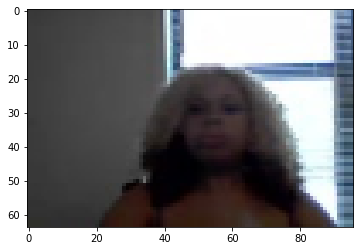

In [34]:
plt.imshow(inst[0][3][24])
print(inst[1][3])

In [35]:
score = model.evaluate(inst[0], inst[1], verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.1703006625175476
Test accuracy: 0.9375


In [36]:
p = inst[0]
p = np.array(p)
p = p.astype('float32')
#print(p)
target = inst[1]
pred = model.predict(p)

pred = np.argmax(pred, axis = 1) 

print(pred)

[ 2  6  7 17 22  9  5  2  9  2 21 17 11 25 22 26]


In [37]:
np.shape(p)

(16, 32, 64, 96, 3)

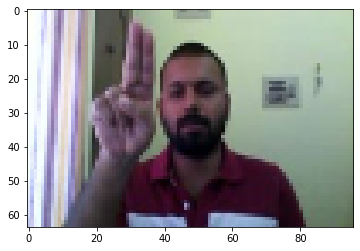

In [38]:
plt.imshow(inst[0][13][16])

In [4]:
import os
classes = os.listdir(PATH)

In [42]:
to_predict = []
num_frames = 0
cap = cv2.VideoCapture(0)
cap.set(12, 50)
cap.set(6, 10)
classe = ''
import time 
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame_cp = frame
    #print(cap.get(6))
    frame_cp = cv2.resize(frame, (96, 64))
    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    to_predict.append(frame_cp)
    to_predict.append(frame_cp)
    
    if len(to_predict) == 32:
        print(".", end="")
        frame_to_predict = [[]]
        frame_to_predict[0] = np.array(to_predict, dtype=np.float32)
        #frame_to_predict = normaliz_data(frame_to_predict)
        #print(frame_to_predict)
        predict = model.predict(np.array(frame_to_predict))
        classe = classes[np.argmax(predict)]
        if np.argmax(predict)!=2:
            print('Class = ',classe, 'Precision = ', np.amax(predict)*100,'%')


        #print(frame_to_predict)
        to_predict = []
        time.sleep(0.1) # Time in seconds
        font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, classe, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0.5, 0.5),1,cv2.LINE_AA)


    # Display the resulting frame
    cv2.imshow('Hand Gesture Recognition',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

.Class =  No gesture Precision =  93.46253275871277 %
.Class =  Stop Sign Precision =  87.99746036529541 %
.Class =  Swiping Up Precision =  89.08411860466003 %
.Class =  Swiping Down Precision =  97.96125888824463 %
.Class =  Swiping Left Precision =  96.382075548172 %
.Class =  Swiping Right Precision =  99.14966821670532 %
..Class =  Sliding Two Fingers Down Precision =  40.50392806529999 %
.Class =  Drumming Fingers Precision =  93.64928007125854 %
.Class =  Sliding Two Fingers Up Precision =  64.24127221107483 %
.Class =  Zooming In With Full Hand Precision =  82.99561738967896 %
.Class =  Zooming Out With Full Hand Precision =  98.45491647720337 %
.Class =  Zooming In With Full Hand Precision =  76.40061378479004 %
.Class =  Zooming Out With Two Fingers Precision =  39.43357467651367 %
.Class =  Zooming In With Two Fingers Precision =  63.147491216659546 %
...Class =  Turning Hand Clockwise Precision =  35.45444905757904 %
.Class =  Shaking Hand Precision =  98.77409338951111 %
.

In [5]:
classes

['Pushing Two Fingers Away',
 'Pushing Hand Away',
 'Doing other things',
 'Turning Hand Clockwise',
 'Zooming In With Two Fingers',
 'Sliding Two Fingers Left',
 'Stop Sign',
 'Pulling Two Fingers In',
 'Drumming Fingers',
 'Sliding Two Fingers Right',
 'Sliding Two Fingers Down',
 'No gesture',
 'Rolling Hand Backward',
 'Swiping Down',
 'Rolling Hand Forward',
 'Turning Hand Counterclockwise',
 'Thumb Down',
 'Swiping Up',
 'Zooming Out With Full Hand',
 'Shaking Hand',
 'Thumb Up',
 'Zooming In With Full Hand',
 'Swiping Right',
 'Zooming Out With Two Fingers',
 'Swiping Left',
 'Sliding Two Fingers Up',
 'Pulling Hand In']